In [ ]:
#!pip install pulp

In [1]:
from pulp import *

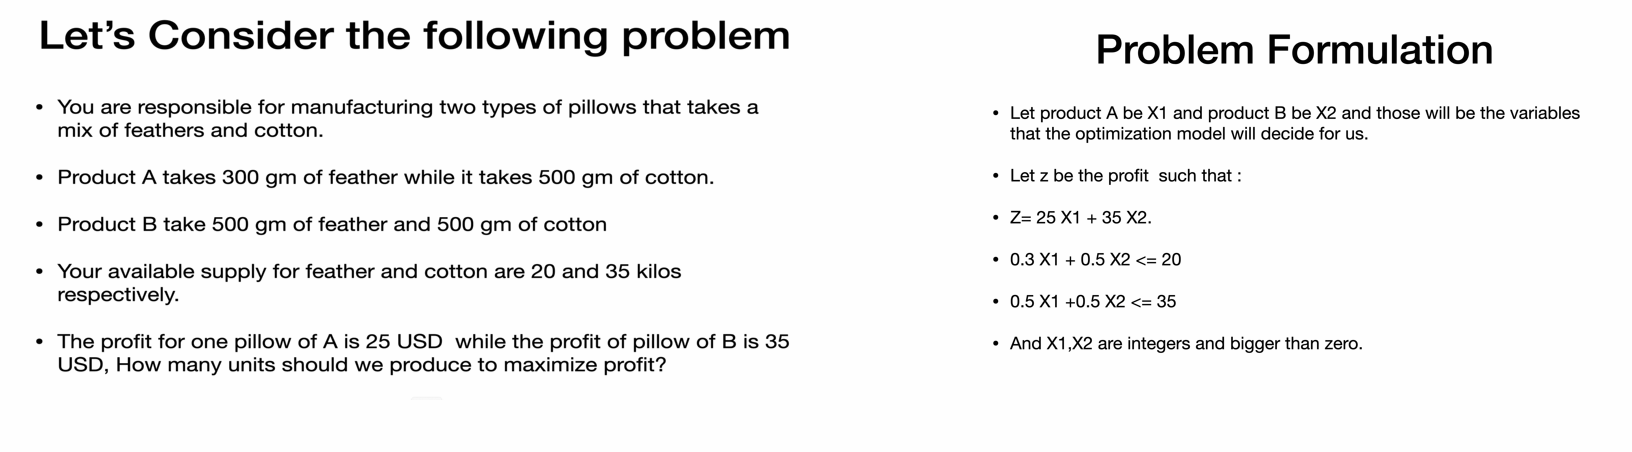

In [2]:
product1 = 25 # $25 for feather
product2 = 35 # $35 for cotton

In [ ]:
# 0.3*X1 + 0.5*X2 <=20
# 0.5*X1+0.5*X2 <=35

In [3]:
model = LpProblem('pillows', LpMaximize)
model

pillows:
MAXIMIZE
None
VARIABLES

In [4]:
X1 = LpVariable('X1',0,None,'Integer')
X2 = LpVariable('X2',0,None,'Integer')

In [5]:
X1

X1

In [6]:
X2

X2

# Define our objective function

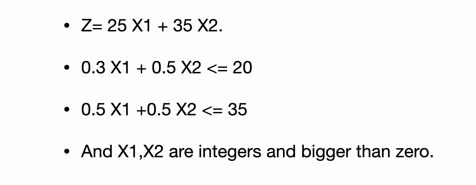

In [7]:
model += X1*25 + X2*35


In [9]:
model

pillows:
MAXIMIZE
25*X1 + 35*X2 + 0
VARIABLES
0 <= X1 Integer
0 <= X2 Integer

In [10]:
model += X1*0.3 + X2*0.5 <=20


In [12]:
model

pillows:
MAXIMIZE
25*X1 + 35*X2 + 0
SUBJECT TO
_C1: 0.3 X1 + 0.5 X2 <= 20

VARIABLES
0 <= X1 Integer
0 <= X2 Integer

In [13]:
model += X1*0.5 + X2*0.5 <= 35

In [14]:
model.solve()

1

In [15]:
X1.varValue

65.0

In [16]:
X2.varValue

1.0

In [18]:
max_profit = product1*X1.varValue + product2*X2.varValue
max_profit

1660.0

# Time Series Forecasting with Supply Chain Dataset

In [ ]:
#!python -m pip install prophet

In [ ]:
#!pip install pystan

In [19]:
import prophet

In [20]:
dir(prophet)

['Path',
 'Prophet',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'about',
 'diagnostics',
 'f',
 'forecaster',
 'hdays',
 'here',
 'make_holidays',
 'models',
 'plot']

In [21]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
from datetime import datetime, date

In [22]:
df = pd.read_csv('Demand_Forecasting_Orders.csv')
df.head()

,Month,CompanyA,CompanyB,Company C,Non-urgent order,Urgent order,Revenue,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders
0,2010-01,316.307,223.270,61.543,175.586,302.448,125,0.000,65556,44914,188411,14793,539.577
1,2010-02,128.633,96.042,38.058,56.037,130.580,135,0.000,40419,21399,89461,7679,224.675
2,2010-03,43.651,84.375,21.826,25.125,82.461,135,1.386,11992,3452,21305,14947,129.412
3,2010-04,171.297,127.667,41.542,113.294,162.284,136,18.156,49971,33703,69054,18423,317.120
4,2010-05,90.532,113.526,37.679,56.618,116.220,149,6.459,48534,19646,16411,20257,210.517


In [47]:
df.tail()

,Month,CompanyA,CompanyB,Company C,Non-urgent order,Urgent order,Revenue,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders
55,2014-08-01,158.716,158.133,59.131,92.639,165.079,700,0.000,32027,33282,128269,9287,316.849
56,2014-09-01,150.784,133.069,54.224,115.746,116.442,685,2.559,51235,34421,87708,11354,286.412
57,2014-10-01,193.534,109.639,58.378,142.382,102.687,695,274.000,28364,88404,91367,15003,303.447
58,2014-11-01,196.555,108.395,76.763,96.478,131.709,725,0.000,37011,109931,50112,12957,304.950
59,2014-12-01,192.116,121.106,107.568,121.152,103.180,715,18.678,27328,108072,56015,10690,331.900


In [23]:
df.shape

(60, 13)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 13 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Month                                      60 non-null     object 
 1   CompanyA                                   60 non-null     float64
 2   CompanyB                                   60 non-null     float64
 3   Company C                                  60 non-null     float64
 4   Non-urgent order                           60 non-null     float64
 5   Urgent order                               60 non-null     float64
 6   Revenue                                    60 non-null     int64  
 7   Order type A                               60 non-null     float64
 8   Order type B                               60 non-null     int64  
 9   Order type C                               60 non-null     int64  
 10  Fiscal sector orders        

In [25]:
df['Month'] = pd.to_datetime(df['Month'])

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 13 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Month                                      60 non-null     datetime64[ns]
 1   CompanyA                                   60 non-null     float64       
 2   CompanyB                                   60 non-null     float64       
 3   Company C                                  60 non-null     float64       
 4   Non-urgent order                           60 non-null     float64       
 5   Urgent order                               60 non-null     float64       
 6   Revenue                                    60 non-null     int64         
 7   Order type A                               60 non-null     float64       
 8   Order type B                               60 non-null     int64         
 9   Order type C           

In [27]:
import statsmodels.api as sm

In [30]:
sm.stats.durbin_watson(df['Revenue'])

0.005389314120579476

<AxesSubplot:>

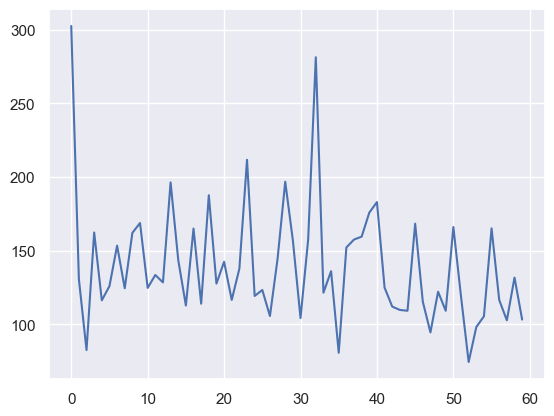

In [32]:
df['Urgent order'].plot()

<AxesSubplot:>

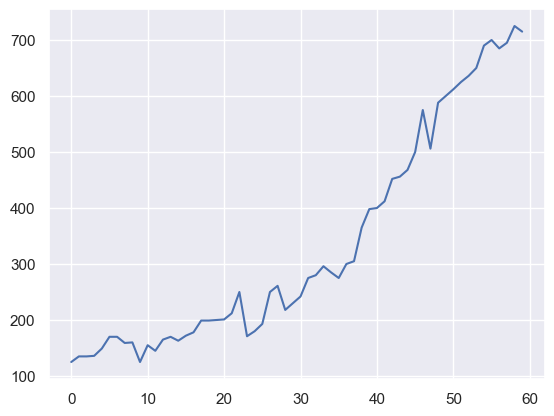

In [33]:
df['Revenue'].plot()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Urgent order'], period=12)
decomposition.plot()
plt.show()

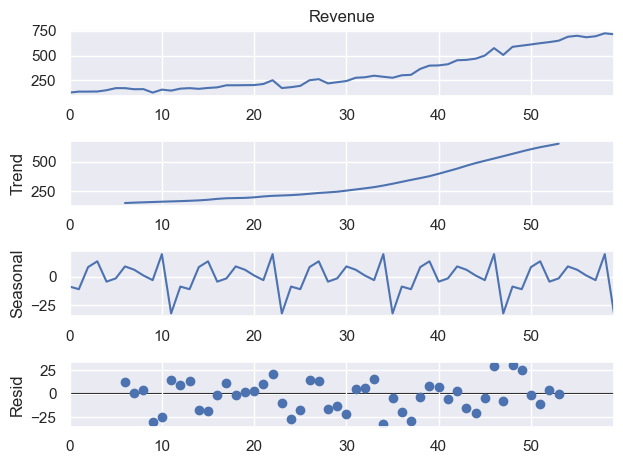

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Revenue'], period=12)
decomposition.plot()
plt.show()

In [37]:
df.columns

Index(['Month', 'CompanyA', 'CompanyB', 'Company C', 'Non-urgent order',
       'Urgent order', 'Revenue', 'Order type A', 'Order type B',
       'Order type C', 'Fiscal sector orders',
       'Orders from the traffic controller sector', 'Banking orders'],
      dtype='object')

In [38]:
total = df.groupby(['Month'])['Non-urgent order','Urgent order', 'Revenue','Banking orders'].sum().reset_index()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20644\1222045717.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total = df.groupby(['Month'])['Non-urgent order','Urgent order', 'Revenue','Banking orders'].sum().reset_index()


In [39]:
total.head()

,Month,Non-urgent order,Urgent order,Revenue,Banking orders
0,2010-01-01,175.586,302.448,125,539.577
1,2010-02-01,56.037,130.580,135,224.675
2,2010-03-01,25.125,82.461,135,129.412
3,2010-04-01,113.294,162.284,136,317.120
4,2010-05-01,56.618,116.220,149,210.517


In [40]:
df_prophet = total.rename(columns={'Month':'ds', 'Revenue':'y'})

In [41]:
df_prophet.head()

,ds,Non-urgent order,Urgent order,y,Banking orders
0,2010-01-01,175.586,302.448,125,539.577
1,2010-02-01,56.037,130.580,135,224.675
2,2010-03-01,25.125,82.461,135,129.412
3,2010-04-01,113.294,162.284,136,317.120
4,2010-05-01,56.618,116.220,149,210.517


In [42]:
from prophet import Prophet

In [43]:
m = Prophet()

In [44]:
m

In [45]:
model = m.fit(df_prophet)

22:26:11 - cmdstanpy - INFO - Chain [1] start processing
22:26:12 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
model.seasonalities

OrderedDict([('yearly',
              {'period': 365.25,
               'fourier_order': 10,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None})])

In [51]:
future_global = model.make_future_dataframe(periods=61, freq='M')

In [52]:
future_global

,ds
0,2010-01-01
1,2010-02-01
2,2010-03-01
3,2010-04-01
4,2010-05-01
...,...
116,2019-08-31
117,2019-09-30
118,2019-10-31
119,2019-11-30


In [53]:
prediction = model.predict(future_global)
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-01,129.644500,98.850058,139.037277,129.644500,129.644500,-10.795888,-10.795888,-10.795888,-10.795888,-10.795888,-10.795888,0.0,0.0,0.0,118.848612
1,2010-02-01,133.362191,98.679792,138.683751,133.362191,133.362191,-14.676516,-14.676516,-14.676516,-14.676516,-14.676516,-14.676516,0.0,0.0,0.0,118.685675
2,2010-03-01,136.720105,117.645737,159.186049,136.720105,136.720105,1.225880,1.225880,1.225880,1.225880,1.225880,1.225880,0.0,0.0,0.0,137.945985
3,2010-04-01,140.437795,123.217490,163.265493,140.437795,140.437795,2.808476,2.808476,2.808476,2.808476,2.808476,2.808476,0.0,0.0,0.0,143.246271
4,2010-05-01,144.035560,122.159762,162.109159,144.035560,144.035560,-2.832897,-2.832897,-2.832897,-2.832897,-2.832897,-2.832897,0.0,0.0,0.0,141.202662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2019-08-31,1821.858527,1603.469278,1965.344861,1633.763751,1991.667632,-29.002561,-29.002561,-29.002561,-29.002561,-29.002561,-29.002561,0.0,0.0,0.0,1792.855965
117,2019-09-30,1840.188413,1599.400499,1967.490004,1647.195025,2016.308161,-46.940567,-46.940567,-46.940567,-46.940567,-46.940567,-46.940567,0.0,0.0,0.0,1793.247847
118,2019-10-31,1859.129297,1712.451179,2093.573445,1662.027731,2040.488929,51.942701,51.942701,51.942701,51.942701,51.942701,51.942701,0.0,0.0,0.0,1911.071997
119,2019-11-30,1877.459183,1651.216698,2040.917925,1673.988410,2064.089335,-26.038734,-26.038734,-26.038734,-26.038734,-26.038734,-26.038734,0.0,0.0,0.0,1851.420450


In [54]:
prediction[['ds','yhat','yhat_lower', 'yhat_upper']].tail(20)

,ds,yhat,yhat_lower,yhat_upper
101,2018-05-31,1579.650509,1459.410193,1688.388272
102,2018-06-30,1583.703825,1458.046433,1693.485027
103,2018-07-31,1565.250687,1433.577734,1684.804065
104,2018-08-31,1574.119906,1443.982530,1692.242963
105,2018-09-30,1576.432651,1440.617900,1698.272460
106,2018-10-31,1679.982294,1535.531851,1804.564399
107,2018-11-30,1626.344592,1477.399786,1754.204503
108,2018-12-31,1657.775156,1505.016353,1792.119032
109,2019-01-31,1710.492659,1551.833686,1850.563173
110,2019-02-28,1678.202844,1516.907965,1819.803555


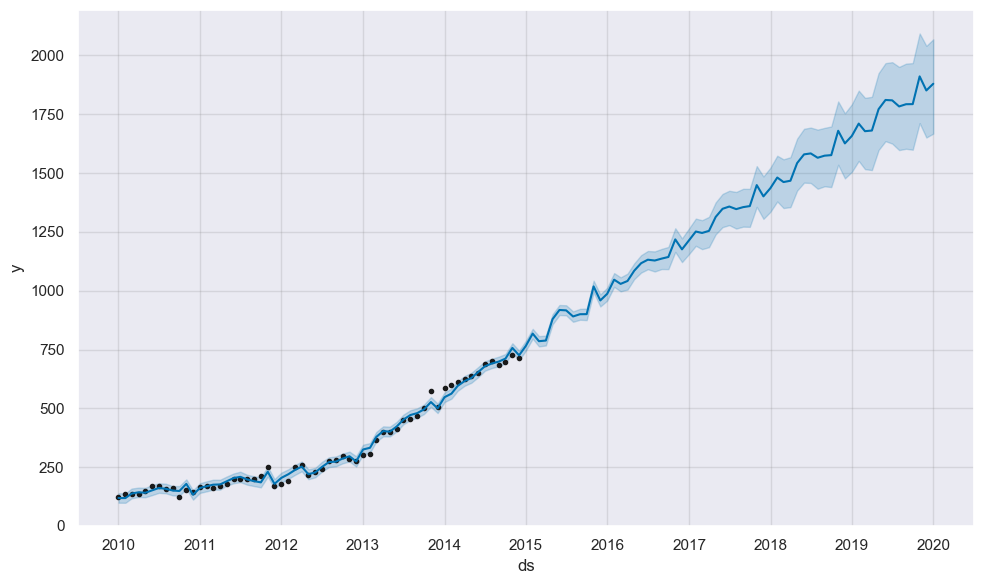

In [56]:
model.plot(prediction)
plt.show()

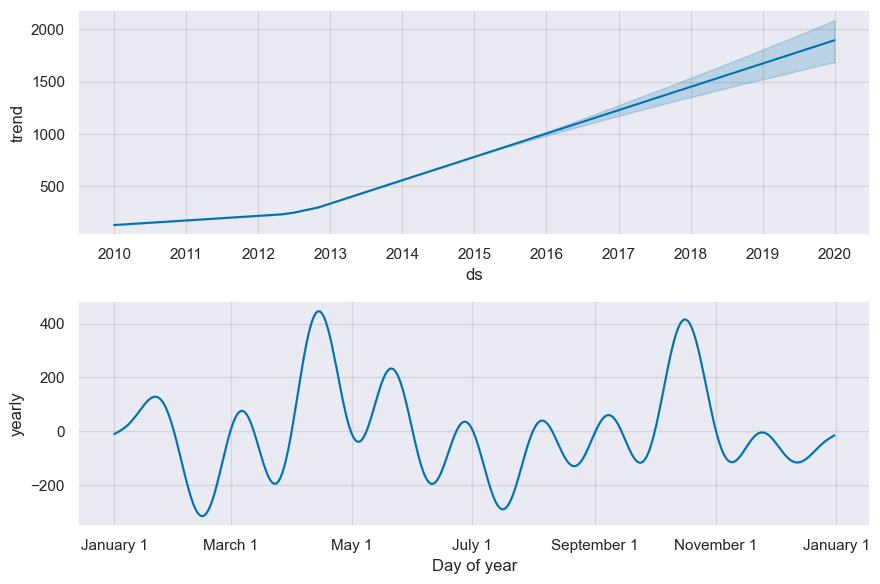

In [57]:
model.plot_components(prediction)
plt.show()